In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
from scipy.io import wavfile
import pandas as pd

In [2]:
folder = './data_2_channels/'
name_first = '_2017_11_10_01_09_11_996_1001.wav'
name_second = '_2017_11_10_01_09_11_996_2050.wav'

sample_rate, signal_first = wavfile.read(folder + name_first)
_, signal_second = wavfile.read(folder + name_second)

if len(signal_first) < len(signal_second):
    signal_second = signal_second[:len(signal_first)]
else:
    signal_first = signal_second[:len(signal_second)]

print('{} kHz, {} s'.format(sample_rate, 1. / sample_rate * len(signal_first)))
print('{} kHz, {} s'.format(sample_rate, 1. / sample_rate * len(signal_second)))

8000 kHz, 79.28 s
8000 kHz, 79.28 s


In [3]:
pre_emphasis = 0.97
signal_first = np.append(signal_first[0], signal_first[1:] - pre_emphasis * signal_first[:-1])
signal_second = np.append(signal_second[0], signal_second[1:] - pre_emphasis * signal_second[:-1])

In [4]:
frame_size = 0.03 # seconds
frame_stride = 0.02 # defines overlap between frames

signal_length = len(signal_first)
frame_length = int(frame_size * sample_rate)
frame_step = int(frame_stride * sample_rate)
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) 

In [5]:
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))

pad_signal_first = np.append(signal_first, z)
pad_signal_second = np.append(signal_second, z)

In [6]:
# framing
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
          np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T

frames_first = pad_signal_first[indices.astype(np.int32, copy=False)]
frames_second = pad_signal_second[indices.astype(np.int32, copy=False)]

In [7]:
%%time

# Fourier & window multiplying
fft = np.fft.fft
power_spectrum_first = 1 / frame_length * np.power(np.abs(fft(frames_first * np.hamming(frame_length))), 2)
power_spectrum_second = 1 / frame_length * np.power(np.abs(fft(frames_second * np.hamming(frame_length))), 2)

freq = np.linspace(0, 2 * sample_rate, frame_length) 
time = np.linspace(0, frame_stride * num_frames, num_frames)

CPU times: user 92 ms, sys: 20 ms, total: 112 ms
Wall time: 111 ms


In [34]:
# viewing spectrogram
observing_time = 79  # seconds
observing_freqs = 8 # kHz

times = np.s_[:np.where(time < observing_time)[0][-1]]
freqs = np.s_[:np.where(freq < observing_freqs * 1e3)[0][-1]]

t = time[times]

est_frames_first = frames_first[(times, np.s_[:])]
est_frames_second = frames_second[(times, np.s_[:])]

In [59]:
average_power_first = np.sum(np.power(est_frames_first, 2), axis=1)
average_power_db_first = 10 * np.log10(average_power_first / np.max(average_power_first))

average_power_second = np.sum(np.power(est_frames_second, 2), axis=1)
average_power_db_second = 10 * np.log10(average_power_second / np.max(average_power_second))

noise_level = np.median(np.minimum(average_power_db_first, average_power_db_second))
signal_level = np.median(np.maximum(average_power_db_first, average_power_db_second))
level = .5 * (noise_level + signal_level)
minimum_pause_time = .5  # s
p = int(minimum_pause_time / frame_stride)

In [60]:
# Results of pauses detecting
t = time[times]
spectrogram_first = np.log10(power_spectrum_first[(times, freqs)]).T
spectrogram_second = np.log10(power_spectrum_second[(times, freqs)]).T

pauses_first = (np.convolve(average_power_db_first < level, np.ones(p), mode='same') == p).astype(int)
pauses_second = (np.convolve(average_power_db_second < level, np.ones(p), mode='same') == p).astype(int)

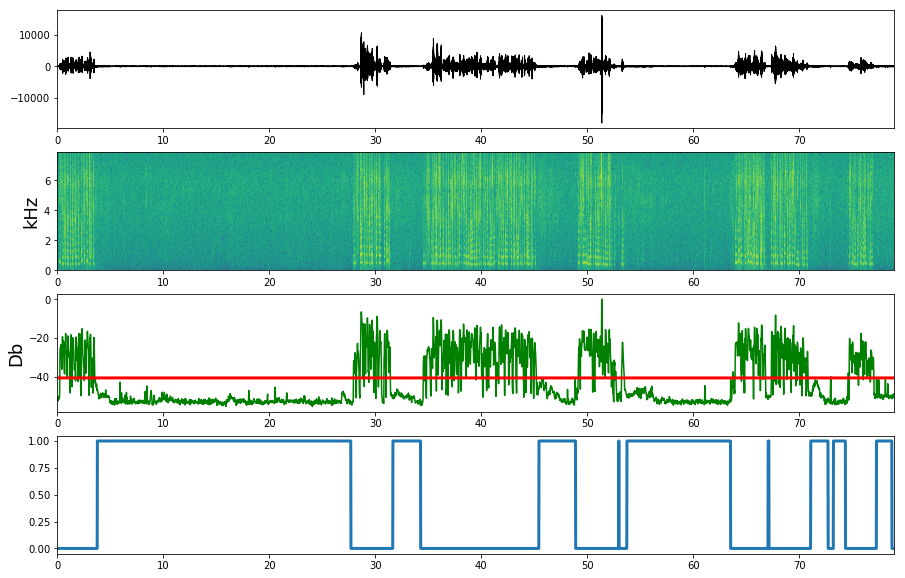

In [61]:
plt.figure(figsize=(15, 10))
plt.subplot(4,1,1)
plt.plot(np.arange(signal_first[:observing_time * sample_rate].size) / 
         sample_rate, signal_first[:observing_time * sample_rate], 'k', lw=1)
plt.xlim(np.min(t), np.max(t))
plt.subplot(4,1,2)
plt.pcolor(t, freq[freqs] / 1e3, spectrogram_first)
plt.ylabel('kHz', fontsize=18)
plt.subplot(4,1,3)
plt.plot(t, average_power_db_first, 'g')
plt.plot(t, level * np.ones_like(time[times]), 'r', lw=3)
plt.ylabel('Db', fontsize=18)
plt.xlim(np.min(t), np.max(t))
plt.subplot(4,1,4)
plt.plot(t, pauses_first, lw=3)
plt.xlim(np.min(t), np.max(t))
plt.show()

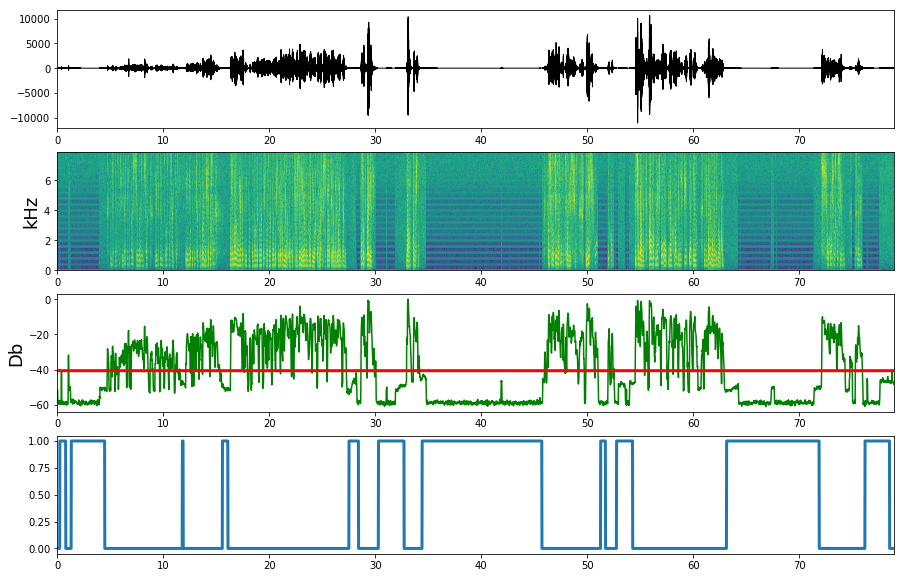

In [62]:
plt.figure(figsize=(15, 10))
plt.subplot(4,1,1)
plt.plot(np.arange(signal_second[:observing_time * sample_rate].size) / 
         sample_rate, signal_second[:observing_time * sample_rate], 'k', lw=1)
plt.xlim(np.min(t), np.max(t))
plt.subplot(4,1,2)
plt.pcolor(t, freq[freqs] / 1e3, spectrogram_second)
plt.ylabel('kHz', fontsize=18)
plt.subplot(4,1,3)
plt.plot(t, average_power_db_second, 'g')
plt.plot(t, level * np.ones_like(time[times]), 'r', lw=3)
plt.ylabel('Db', fontsize=18)
plt.xlim(np.min(t), np.max(t))
plt.subplot(4,1,4)
plt.plot(t, pauses_second, lw=3)
plt.xlim(np.min(t), np.max(t))
plt.show()

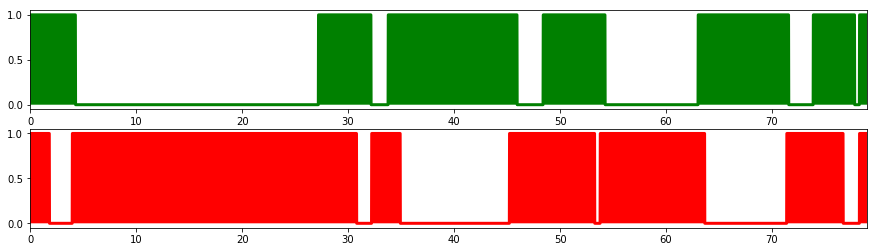

In [13]:
plt.figure(figsize=(15, 4))
plt.subplot(2,1,1)
plt.plot(t, 1 - pauses_first, 'g', lw=3)
plt.fill_between(t, np.zeros_like(t), 1 - pauses_first, facecolor='green')
plt.xlim(np.min(t), np.max(t))
plt.subplot(2,1,2)
plt.plot(t, 1 - pauses_second, 'r', lw=3)
plt.fill_between(t, np.zeros_like(t), 1 - pauses_second, facecolor='red')
plt.xlim(np.min(t), np.max(t))
plt.show()

In [14]:
# dialogs bounds defining
def replica(x):
    replicas = np.hstack((0, x, 0))
    d_replicas = np.diff(replicas)
    return np.hstack((np.where(d_replicas > 0)[0], np.where(d_replicas < 0)[0])).reshape(2, -1)

replicas_id_first = replica(1 - pauses_first)
replicas_id_second = replica(1 - pauses_second)

replicas_id_first, replicas_id_second

(array([[   0, 1360, 1689, 2420, 3151, 3694, 3912],
        [ 214, 1608, 2297, 2712, 3578, 3889, 3949]]),
 array([[   0,  199, 1611, 2261, 2689, 3569, 3912],
        [  91, 1540, 1746, 2663, 3182, 3835, 3949]]))

In [15]:
#  converting replicas to dialog
def replicas2dialog(first, second):
    f = first.copy()
    s = second.copy()
    
    dialog = -np.ones((3, f.shape[1] + s.shape[1]), dtype=int)
    for segment in np.arange(f.shape[1]+s.shape[1]):        
        if f[0, 0] < s[0, 0]:
            dialog[:2, segment] = f[:, 0]
            dialog[2, segment] = 0
            f = np.delete(f, 0, axis=1)
        else:
            dialog[:2, segment] = s[:, 0]
            dialog[2, segment] = 1
            s = np.delete(s, 0, axis=1)
            
        if f.shape[1] == 0:
            dialog[:2, -1-s.shape[1]:-1] = s
            dialog[2, -1-s.shape[1]:-1] = 1
            break
        elif s.shape[1] == 0:
            dialog[:2, -f.shape[1]:] = f
            dialog[2, -f.shape[1]:] = 0
            break
    return dialog

In [16]:
df = pd.DataFrame(data=replicas2dialog(replicas_id_first, replicas_id_second).T,    # values
             columns=['start_frame', 'end_frame', 'label'])

df['start'] = df['start_frame'] * frame_step
df['end'] = df['end_frame'] * frame_step
df['time'] = 1. / sample_rate * (df['end'] - df['start'])
df['length'] = df['end'] - df['start']

In [17]:
df = df[df['time'] > 1.5] #  more tahn 1.5s
df

,start_frame,end_frame,label,start,end,time,length
0,0,91,1,0,14560,1.82,14560
1,0,214,0,0,34240,4.28,34240
2,199,1540,1,31840,246400,26.82,214560
3,1360,1608,0,217600,257280,4.96,39680
4,1611,1746,1,257760,279360,2.70,21600
5,1689,2297,0,270240,367520,12.16,97280
6,2261,2663,1,361760,426080,8.04,64320
7,2420,2712,0,387200,433920,5.84,46720
8,2689,3182,1,430240,509120,9.86,78880
9,3151,3578,0,504160,572480,8.54,68320


In [21]:
from recognizer import Recognizer
recognizer = Recognizer()
wavwrite = scipy.io.wavfile.write


MAX_TIME_TRESHOLD = 10  # seconds
TIME_OVERLAP = 2

senses = []
for segment in np.arange(df.shape[0]):
    print('Replica {} recognized'.format(segment))
    if df['label'][segment] == 0:
        replica = signal_first[df['start'][segment]:df['end'][segment]].astype(np.int16)
    else:
        replica = signal_second[df['start'][segment]:df['end'][segment]].astype(np.int16)
    
    # checking if size is too big and recognizing
    if df['time'][segment] < MAX_TIME_TRESHOLD:
        wavwrite('replica.wav', sample_rate, replica)
        senses.append(recognizer.get_senses())
    else:
        senses.append([])

        treshold_p = MAX_TIME_TRESHOLD * sample_rate
        overlap_p = TIME_OVERLAP * sample_rate
        
        parts_count = np.ceil((df['length'][segment] - overlap_p) / (treshold_p - overlap_p)).astype(int)
        parts_starts = np.arange(parts_count) * (treshold_p - overlap_p)
        parts_idxs = np.repeat(np.arange(treshold_p).reshape(-1, 1), parts_count, axis=1) + parts_starts
        replica = np.append(replica, np.zeros(parts_count * treshold_p - df['length'][segment], dtype=np.int16))
        for part in np.arange(parts_idxs.shape[1]):
            wavwrite('replica.wav', sample_rate, replica[parts_idxs[:, part]])
            senses[-1].append(recognizer.get_senses())

Replica 0 recognized
Replica 1 recognized
Replica 2 recognized
Replica 3 recognized
Replica 4 recognized
Replica 5 recognized
Replica 6 recognized
Replica 7 recognized
Replica 8 recognized
Replica 9 recognized
Replica 10 recognized
Replica 11 recognized


In [22]:
senses

['',
 'единый информационный центр vsc готовности здравствуйте',
 ['интерсвязь зарегистрироваться на сайте не получается',
  'получается ли я на почту не приходил',
  'не приходит код подтверждения я звонила фотографию считают себя на билайне можно проверить',
  'можно ли проверить'],
 'значки галочки 2 в конце регистрации поставили',
 'да конечно',
 ['в данной ситуации желательно будет попробовать пройти регистрацию через другой браузер данных ошибок возникать не должно если вы выполняете все поля тула',
  'как заполнять все поля то ваз регистрации должна пройти'],
 'скажите пожалуйста можно проверить счет',
 'мы не имеем доступа именно в личные данные участников да',
 'личные данные о вот мне сказали принести инн индивидуальный номер ребенка',
 'мой номер будет присвоен именно после регистрации он придет на электронную почту и будет в личном кабинете указываться',
 'все хорошо спасибо',
 'спасибо за звонок всего доброго до свидания']